In [1]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import soundfile as sf
from autostep3.util import NDFloatArray, cutoff_samples, stereo2mono

def plot_large(*data):
	ax: Axes
	_, ax = plt.subplots(1, figsize=(20, 5))
	ax.plot(*data)

In [1]:
import shutil
from spleeter.audio import Codec
from sys import argv, stderr
import soundfile as sf
from os import path
from autostep3 import better_aubio
from autostep3.util import NDIntArray, sample2note, highest_index
import numpy as np

### Constants (we can paramaterize these later)

# Spleeter: separation destination directory
SEP_DEST_DIR = "separated_audio"

# Spleeter: separated audio codec
# MP3s save a lot of space compared to WAVs, so I think this is the best default
CODEC = Codec.MP3

# Whether to separate even if already separated
FORCE_SEP = False

audio_path = "test_audio/hyperpop.mp3"
audio_file_name = audio_path[highest_index(audio_path, '/')+1:highest_index(audio_path, '.')]

def separate_drums(audio_path: str, force: bool = False):
	audio_file_name = audio_path[highest_index(audio_path, '/')+1:highest_index(audio_path, '.')]
	if force or not path.exists(f'/tmp/{audio_file_name}'):
		from spleeter.separator import Separator
		separator = Separator("spleeter:5stems")
		separator.separate_to_file(audio_path, '/tmp', codec=CODEC, synchronous=True)
	shutil.copyfile(f'/tmp/{audio_file_name}/drums.wav')

if FORCE_SEP or not path.exists(path.join(SEP_DEST_DIR, audio_file_name)):
	# This import takes a while, so import it only when needed
	from spleeter.separator import Separator
	separator = Separator("spleeter:5stems")
	separator.separate_to_file(audio_path, SEP_DEST_DIR, codec=CODEC, synchronous=True)

drums_path = path.join(SEP_DEST_DIR, audio_file_name, "drums." + CODEC)
audio, samplerate = sf.read(drums_path, dtype='float32')

num_samples = sf.info(drums_path).frames

tempo = better_aubio.tempo_cli(drums_path)

[mp3float @ 0x55eed7f0f980] Could not update timestamps for skipped samples.
[mp3float @ 0x55eed7f0f980] Could not update timestamps for discarded samples.


In [4]:
import numpy as np

onsets_sixteenth_notes = np.int_(sample2note(onsets, samplerate, tempo, 16))

print(onsets_sixteenth_notes.shape)
print(onsets_sixteenth_notes)

(862,)
[   0    5   36   67   81   83  104  114  115  119  123  124  125  127
  128  129  131  132  133  135  136  137  139  140  140  142  143  144
  146  147  148  150  151  152  154  155  156  158  159  160  162  163
  164  166  167  168  169  170  171  173  174  175  177  178  179  181
  182  183  185  186  187  189  190  191  193  194  195  197  197  198
  200  201  202  204  205  206  207  208  209  210  212  213  214  216
  217  218  220  221  222  224  225  225  227  228  229  231  232  233
  235  236  237  239  240  241  243  244  245  247  248  249  251  253
  255  255  256  258  259  260  262  263  264  266  267  268  270  271
  272  274  275  276  278  279  280  282  282  283  285  286  287  289
  290  291  293  294  295  297  298  299  301  302  303  305  306  307
  309  310  310  312  313  314  316  317  318  320  321  322  324  325
  326  328  329  330  332  333  334  336  337  338  339  340  341  343
  344  345  347  348  349  351  352  353  355  356  357  359  360  361

In [4]:
onsets = better_aubio.onset(drums_path, 'specflux')
onsets.shape

[mp3float @ 0x55a6c9d2d280] Could not update timestamps for skipped samples.
[mp3float @ 0x55a6c9d2d280] Could not update timestamps for discarded samples.


(974,)

In [8]:
audible_onsets = np.empty(num_samples, dtype='float32')
for i in range(num_samples):
	audible_onsets[i] = 1 if i in onsets else 0
sf.write("audible_onsets.MP3", audible_onsets, samplerate)

In [2]:
import sounddevice as sd
import threading

streams = sd.OutputStream(channels=2, samplerate=samplerate), sd.OutputStream(channels=1, samplerate=samplerate)

for stream in streams:
	stream.start()

new_audio, _ = sf.read("AUDIBLE_ONSETS.MP3", dtype='float32')

threading.Thread(target=lambda: streams[0].write(audio)).start()
streams[1].write(new_audio)

In [10]:
streams[0].stop()

<BarContainer object of 1240 artists>

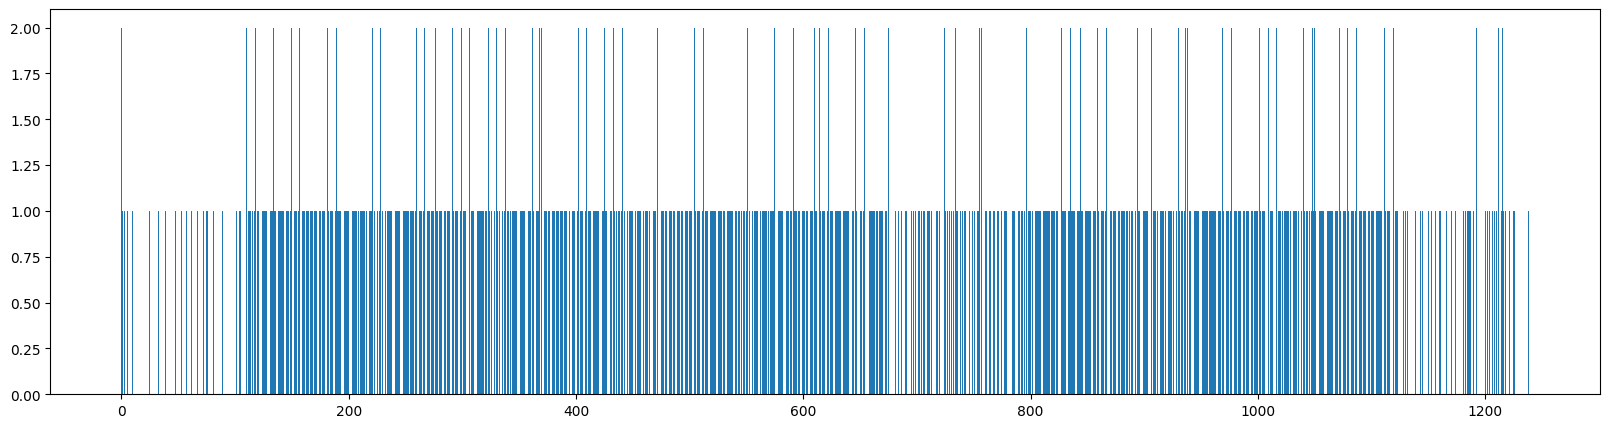

In [16]:
import matplotlib.pyplot as plt

x_range = range(max(onsets_sixteenth_notes))
y_range = tuple(np.count_nonzero(onsets_sixteenth_notes == n) for n in x_range)

fig, ax = plt.subplots(1, figsize=(20, 5))
ax.bar(x_range, y_range)

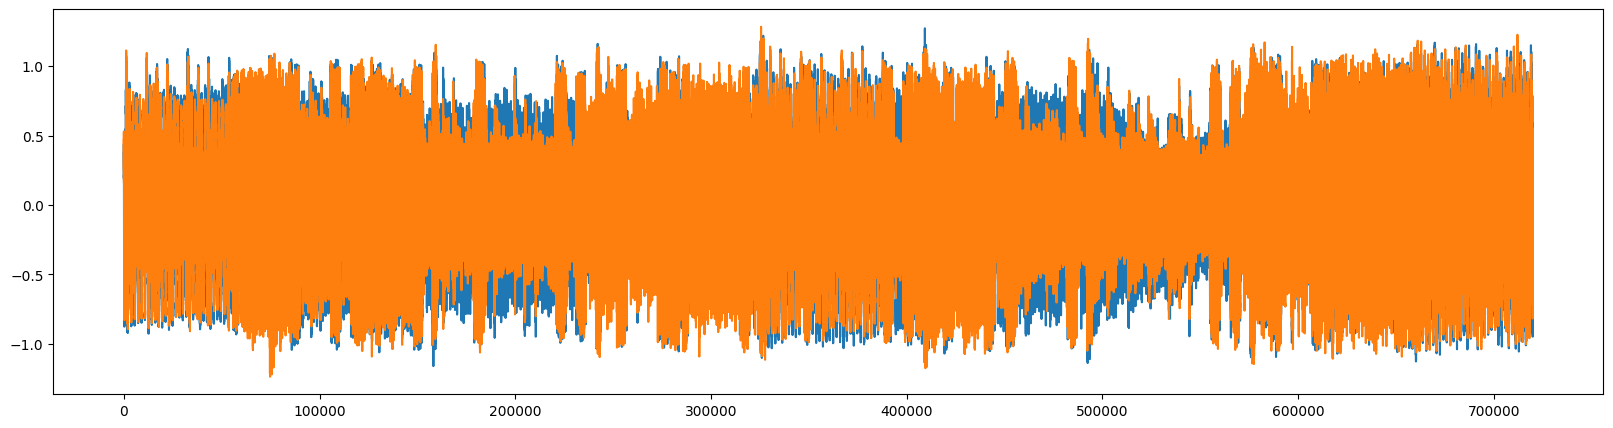

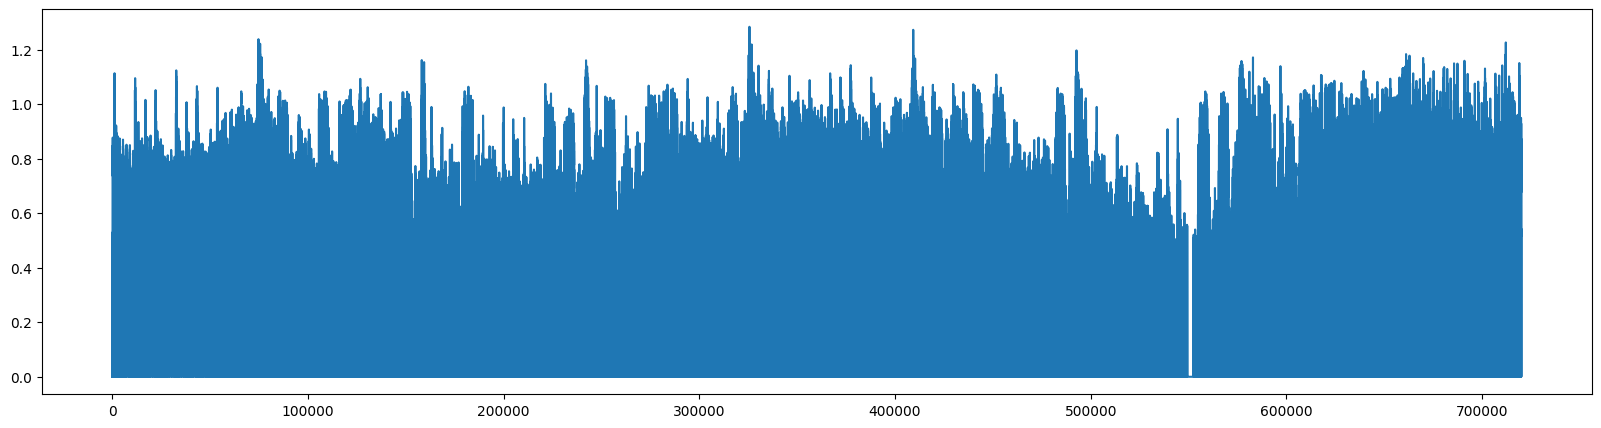

In [85]:
audio, samplerate = sf.read("test_audio/hyperpop.mp3")
audio = audio[15*samplerate:30*samplerate]
cutoff_audio = np.max(np.abs(audio.copy()), axis=1)
cutoff_samples(cutoff_audio, 0.5)
plot_large(audio)
plot_large(cutoff_audio)


In [86]:
sd.play(cutoff_audio, samplerate)

In [64]:
sd.play(audio)

In [8]:
x = path.join(SEP_DEST_DIR, audio_file_name)
print(x)
path.exists(x)

/hyperpop


False